In [1]:
import os
import datetime
import sklearn
from sklearn import *
import time
import pandas as pd
import pickle
import xgboost
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
def read_files(dir_input, begin_date, end_date):
    data_list = []
    all_files = [os.path.join(dir_input, f) for f in os.listdir(dir_input) if f>=begin_date+'.pkl' and f<=end_date+'.pkl']
    
    for filename in all_files:
        try:
            df = pd.read_pickle(filename)
            data_list.append(df)
            del df
        except:
            continue
    return pd.concat(data_list, ignore_index=True)

In [3]:
DIR_INPUT='/kaggle/input/transactions/data' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 364 ms, sys: 441 ms, total: 805 ms
Wall time: 2.11 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [4]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_compromised_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-06-11", "%Y-%m-%d")
delta_train = 70
delta_delay = 10
delta_test = 15

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=10,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

/tmp/ipykernel_35/3769397631.py:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
/tmp/ipykernel_35/3769397631.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
/tmp/ipykernel_35/3769397631.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'

In [5]:
transactions_df.head()

TRANSACTION_ID         TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0          843768 2018-06-28 00:00:31         1759         5674      86.86   
1          843769 2018-06-28 00:01:05         1038         6405     118.32   
2          843770 2018-06-28 00:01:43         1858          282       7.36   
3          843771 2018-06-28 00:04:36         1221           48     116.11   
4          843772 2018-06-28 00:05:48         1931         4700      86.03   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  \
0          7603231            88         0                  0   
1          7603265            88         0                  0   
2          7603303            88         0                  0   
3          7603476            88         0                  0   
4          7603548            88         0                  0   

   TX_DURING_WEEKEND  ...  CUSTOMER_ID_NB_TX_7DAY_WINDOW  \
0                  0  ...                           29.0   
1                  0  ...                           18.0   
2                  0  ...                            1.0   
3                  0  ...                           20.0   
4                  0  ...                           31.0   

   CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW  CUSTOMER_ID_NB_TX_30DAY_WINDOW  \
0                           70.676552                           113.0   
1                           85.708889                            87.0   
2                            7.360000                             5.0   
3                          107.632000                            74.0   
4                           81.587097                           107.0   

   CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  TERMINAL_ID_NB_TX_1DAY_WINDOW  \
0                            74.364336                            1.0   
1                            71.810575                            2.0   
2                            27.822000                            1.0   
3                           101.180541                            1.0   
4                            76.854299                            0.0   

   TERMINAL_ID_RISK_1DAY_WINDOW  TERMINAL_ID_NB_TX_7DAY_WINDOW  \
0                           0.0                            6.0   
1                           0.0                            5.0   
2                           0.0                            5.0   
3                           0.0                           11.0   
4                           0.0                            5.0   

   TERMINAL_ID_RISK_7DAY_WINDOW  TERMINAL_ID_NB_TX_30DAY_WINDOW  \
0                           0.0                            34.0   
1                           0.0                            24.0   
2                           0.0                            30.0   
3                           0.0                            50.0   
4                           0.0                            29.0   

   TERMINAL_ID_RISK_30DAY_WINDOW  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 23 columns]

In [6]:
def get_train_test_set(transactions_df, start_date_training, delta_train=7, delta_delay=7, delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [7]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-06-11", "%Y-%m-%d")
delta_train=70
delta_delay=10
delta_test=15

(train_df, test_df) = get_train_test_set(transactions_df, start_date_training, delta_train, delta_delay, delta_test)

print(train_df.shape)
print(train_df[train_df.TX_FRAUD==1].shape)
print(test_df.shape)
print(test_df[test_df.TX_FRAUD==1].shape)

(670720, 23)
(5947, 23)
(65870, 23)
(427, 23)


In [8]:
test_df

TRANSACTION_ID         TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
756773         1447244 2018-08-30 00:01:18          868         2469   
756777         1447248 2018-08-30 00:03:03         1777         1840   
756778         1447249 2018-08-30 00:04:04         3937         7504   
756780         1447251 2018-08-30 00:06:05         1087          650   
756782         1447253 2018-08-30 00:09:44          337         7631   
...                ...                 ...          ...          ...   
574370         1591163 2018-09-13 23:53:37         1542         7976   
574371         1591164 2018-09-13 23:54:37         4679         1796   
574375         1591168 2018-09-13 23:58:06         2630          368   
574376         1591169 2018-09-13 23:58:27         3232          472   
574379         1591172 2018-09-13 23:59:52          238         9856   

        TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  \
756773      16.19         13046478           151         0                  0   
756777      18.03         13046583           151         0                  0   
756778      72.28         13046644           151         0                  0   
756780      15.70         13046765           151         0                  0   
756782      28.08         13046984           151         0                  0   
...           ...              ...           ...       ...                ...   
574370      16.53         14342017           165         0                  0   
574371      55.32         14342077           165         0                  0   
574375      79.08         14342286           165         0                  0   
574376       5.08         14342307           165         0                  0   
574379      17.22         14342392           165         0                  0   

        TX_DURING_WEEKEND  ...  CUSTOMER_ID_NB_TX_7DAY_WINDOW  \
756773                  0  ...                            8.0   
756777                  0  ...                           30.0   
756778                  0  ...                           18.0   
756780                  0  ...                           19.0   
756782                  0  ...                           10.0   
...                   ...  ...                            ...   
574370                  0  ...                           26.0   
574371                  0  ...                           17.0   
574375                  0  ...                           22.0   
574376                  0  ...                           26.0   
574379                  0  ...                            7.0   

        CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW  CUSTOMER_ID_NB_TX_30DAY_WINDOW  \
756773                           21.616250                            23.0   
756777                           17.932333                           130.0   
756778                           89.139444                            90.0   
756780                           10.197368                            56.0   
756782                           31.179000                            38.0   
...                                    ...                             ...   
574370                            7.915385                            87.0   
574371                           37.348235                           103.0   
574375                           62.207727                            91.0   
574376                            4.808077                            92.0   
574379                           18.961429                            36.0   

        CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  TERMINAL_ID_NB_TX_1DAY_WINDOW  \
756773                            19.092174                            0.0   
756777                            18.462769                            0.0   
756778                            83.592000                            0.0   
756780                             9.168929                            2.0   
756782                            30.566842                   

In [9]:
OUTPUT_FEATURES = "TX_FRAUD"

INPUT_FEATURES = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

# Model Training

In [11]:
def scale_data(train_df, test_df, features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train_df[features])

    # with open('scaler.pkl', 'wb') as f:
    #     pickle.dump(scaler, f)
    
    train_df[features]=scaler.transform(train_df[features])
    test_df[features]=scaler.transform(test_df[features])
    
    return (train_df,test_df)


def fit_model_and_get_predictions(classifier, train_df, test_df, input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scale_data(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [12]:
classifier = sklearn.ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model_and_predictions = fit_model_and_get_predictions(classifier, train_df, test_df, INPUT_FEATURES, OUTPUT_FEATURES)

In [13]:
classifier

RandomForestClassifier(n_jobs=-1, random_state=0)

In [25]:
classifiers_dictionary={'logistic_regression': sklearn.linear_model.LogisticRegression(random_state=0), 
                        'decision_tree_depth_2': sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'decision_tree_unlimited_depth': sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'random_forest': sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'xgboost': xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

all_predictions_dict = {}

for classifier_name in classifiers_dictionary:
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, INPUT_FEATURES, OUTPUT_FEATURES)
    all_predictions_dict[classifier_name]=model_and_predictions

In [14]:
decision_tree_dict = all_predictions_dict['decision_tree_depth_2']
random_forest_dict = all_predictions_dict['random_forest']
xgboost_dict = all_predictions_dict['xgboost']

NameError: name 'all_predictions_dict' is not defined

In [27]:
random_forest_dict = all_predictions_dict['random_forest']
pd.DataFrame(random_forest_dict['predictions_test']).describe()

0
count  65870.000000
mean       0.006784
std        0.060751
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

In [14]:
test_df['TX_FRAUD_PREDICTED'] = model_and_predictions['predictions_test']
test_df[test_df.TX_FRAUD==1][['TRANSACTION_ID', 'TX_FRAUD', 'TX_FRAUD_PREDICTED']]

TRANSACTION_ID  TX_FRAUD  TX_FRAUD_PREDICTED
756802         1447273         1                0.98
757157         1447628         1                0.99
757190         1447661         1                0.00
757980         1448451         1                0.99
758152         1448623         1                0.99
...                ...       ...                 ...
571864         1588657         1                0.58
571965         1588758         1                0.94
571991         1588784         1                0.98
572520         1589313         1                0.93
573477         1590270         1                0.00

[427 rows x 3 columns]

In [15]:
# import shutil
# shutil.rmtree("/kaggle/working")

# Evaluation Functions

## ROC AUC

In [15]:
from sklearn.metrics import roc_auc_score

def roc_auc(model, test_df):
    y_pred_proba = model.predict_proba(test_df[INPUT_FEATURES])[:, 1]
    y_true = test_df['TX_FRAUD']
    return roc_auc_score(y_true, y_pred_proba)

## Precision Top-k

In [16]:
def precision_top_k_day(df_day, top_k=100):
    
    # Order transactions by decreasing probabilities of frauds
    df_day = df_day.sort_values(by="predictions", ascending=False).reset_index(drop=False)
    # print(df_day)
        
    # Get the top k most suspicious transactions
    df_day_top_k=df_day.head(top_k)
    list_detected_fraudulent_transactions=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].TRANSACTION_ID)
    
    # Compute precision top k
    precision_top_k = len(list_detected_fraudulent_transactions) / top_k
    
    return list_detected_fraudulent_transactions, precision_top_k

In [17]:
def precision_top_k(predictions_df, top_k=100):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    precision_top_k_per_day_list = []
    nb_fraudulent_transactions_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_FRAUD', 'predictions']]
        
        nb_fraudulent_transactions_per_day.append(len(df_day[df_day.TX_FRAUD==1]))
        
        _, _precision_top_k = precision_top_k_day(df_day, top_k=top_k)
        
        precision_top_k_per_day_list.append(_precision_top_k)
        
    # Compute the mean
    mean_precision_top_k = np.round(np.array(precision_top_k_per_day_list).mean(),3)
    
    # Returns number of fraudulent transactions per day,
    # precision top k per day, and resulting mean
    return nb_fraudulent_transactions_per_day,precision_top_k_per_day_list,mean_precision_top_k

## Card Precision Top-k

In [18]:
def card_precision_top_k_day(df_day, top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
    
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

In [19]:
def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

# Model Validation

## Prequential Split

In [33]:
delta_assessment = 7
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices


n_folds = 4
prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import randint
# import warnings
# warnings.filterwarnings('ignore')

# Step 1: Initialize the base model
random_forest_classifier = random_forest_dict['classifier']

# Step 2: Define hyperparameter search space
param_dist = {
    'clf__n_estimators': randint(120, 150),   
    'clf__max_depth': randint(5, 15),     
    'clf__min_samples_split': randint(5, 15),    
    'clf__min_samples_leaf': [randint(5, 15),
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}


# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    random_forest_classifier,
    param_distributions=param_dist,
    n_iter=10,              # number of settings to try
    cv=3,
    scoring='roc_auc',      # optimize AUC
    n_jobs=-1,              # use all cores
    verbose=1,
    random_state=42,
    refit=False
)

# Step 4: Run the search
X_train = transactions_df[INPUT_FEATURES]
y_train = transactions_df[OUTPUT_FEATURES]

random_search.fit(X_train, y_train)

# Step 5: Best params & score
print("✅ Best Parameters:")
print(random_search.best_params_)
print("\n✅ Best CV ROC AUC:", random_search.best_score_)

# # Step 6: Evaluate on the test set
# best_model = random_search.best_estimator_
# y_pred_prob = best_model.predict_proba(X_test)[:, 1]
# y_pred_class = best_model.predict(X_test)

# print("\n✅ Test ROC AUC:", roc_auc_score(y_test, y_pred_prob))
# print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

NameError: name 'random_forest_dict' is not defined

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

best_params = {
    'bootstrap': True,
    'max_depth': 17,
    'max_features': 'sqrt',
    'min_samples_leaf': 7,
    'min_samples_split': 9,
    'n_estimators': 132
}

best_model = Pipeline([
    ('clf', RandomForestClassifier(
        **best_params,
        n_jobs=-1,
        random_state=42
    ))
])

best_model.fit(train_df[INPUT_FEATURES], train_df[OUTPUT_FEATURES])

In [23]:
with open('best_random_forest.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Model Evaluation

In [28]:
decision_tree_dict = all_predictions_dict['decision_tree_depth_2']
random_forest_dict = all_predictions_dict['random_forest']
xgboost_dict = all_predictions_dict['xgboost']

## ROC AUC

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_df.TX_FRAUD, test_df.TX_FRAUD_PREDICTED)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [38]:
print(roc_auc(classifier, test_df))
print(roc_auc(best_model, test_df))

0.8717777928634179
0.8765889947456286


## Precision Top-k

In [19]:
predictions_df = test_df
predictions_df['predictions'] = model_and_predictions['predictions_test']
predictions_df[['TRANSACTION_ID','TX_DATETIME','CUSTOMER_ID','TERMINAL_ID','TX_AMOUNT','TX_TIME_DAYS','TX_FRAUD','predictions']].head()

TRANSACTION_ID         TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
756773         1447244 2018-08-30 00:01:18          868         2469   
756777         1447248 2018-08-30 00:03:03         1777         1840   
756778         1447249 2018-08-30 00:04:04         3937         7504   
756780         1447251 2018-08-30 00:06:05         1087          650   
756782         1447253 2018-08-30 00:09:44          337         7631   

        TX_AMOUNT  TX_TIME_DAYS  TX_FRAUD  predictions  
756773  -0.889438           151         0          0.0  
756777  -0.845731           151         0          0.0  
756778   0.442919           151         0          0.0  
756780  -0.901078           151         0          0.0  
756782  -0.607004           151         0          0.0

In [20]:
day=151

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['TRANSACTION_ID','CUSTOMER_ID', 'TX_FRAUD', 'predictions']]

_, precision_top_k_score= precision_top_k_day(df_day=df_day, top_k=100)
precision_top_k_score

0.19

In [24]:
nb_fraudulent_transactions_per_day_remaining,precision_top_k_per_day_list, mean_precision_top_k = precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining fraudulent transactions: " + str(nb_fraudulent_transactions_per_day_remaining))
print("Precision top-k: " + str(precision_top_k_per_day_list))
print("Average Precision top-k: " + str(mean_precision_top_k))

Number of remaining fraudulent transactions: [27, 30, 34, 27, 34, 34, 30, 34, 23, 22, 30, 24, 27, 32, 19]
Precision top-k: [0.19, 0.18, 0.27, 0.21, 0.24, 0.23, 0.24, 0.26, 0.18, 0.16, 0.24, 0.19, 0.18, 0.23, 0.15]
Average Precision top-k: 0.21


In [55]:
# Compute the number of transactions per day, 
#fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Lấy index của 15 ngày cuối
test_idx = tx_stats.tail(15).index

# Gán dữ liệu
tx_stats.loc[test_idx, 'nb_fraudulent_transactions_per_day_remaining'] = nb_fraudulent_transactions_per_day_remaining
tx_stats.loc[test_idx, 'precision_top_k_per_day'] = precision_top_k_per_day_list

/tmp/ipykernel_35/1986577415.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day - Original')
/tmp/ipykernel_35/1986577415.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day_remaining'], 'b', color=colors['nb_fraudulent_transactions_per_day_remaining'], label = '# fraudulent txs per day - Remaining')
/tmp/ipykernel_35/1986577415.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take prec

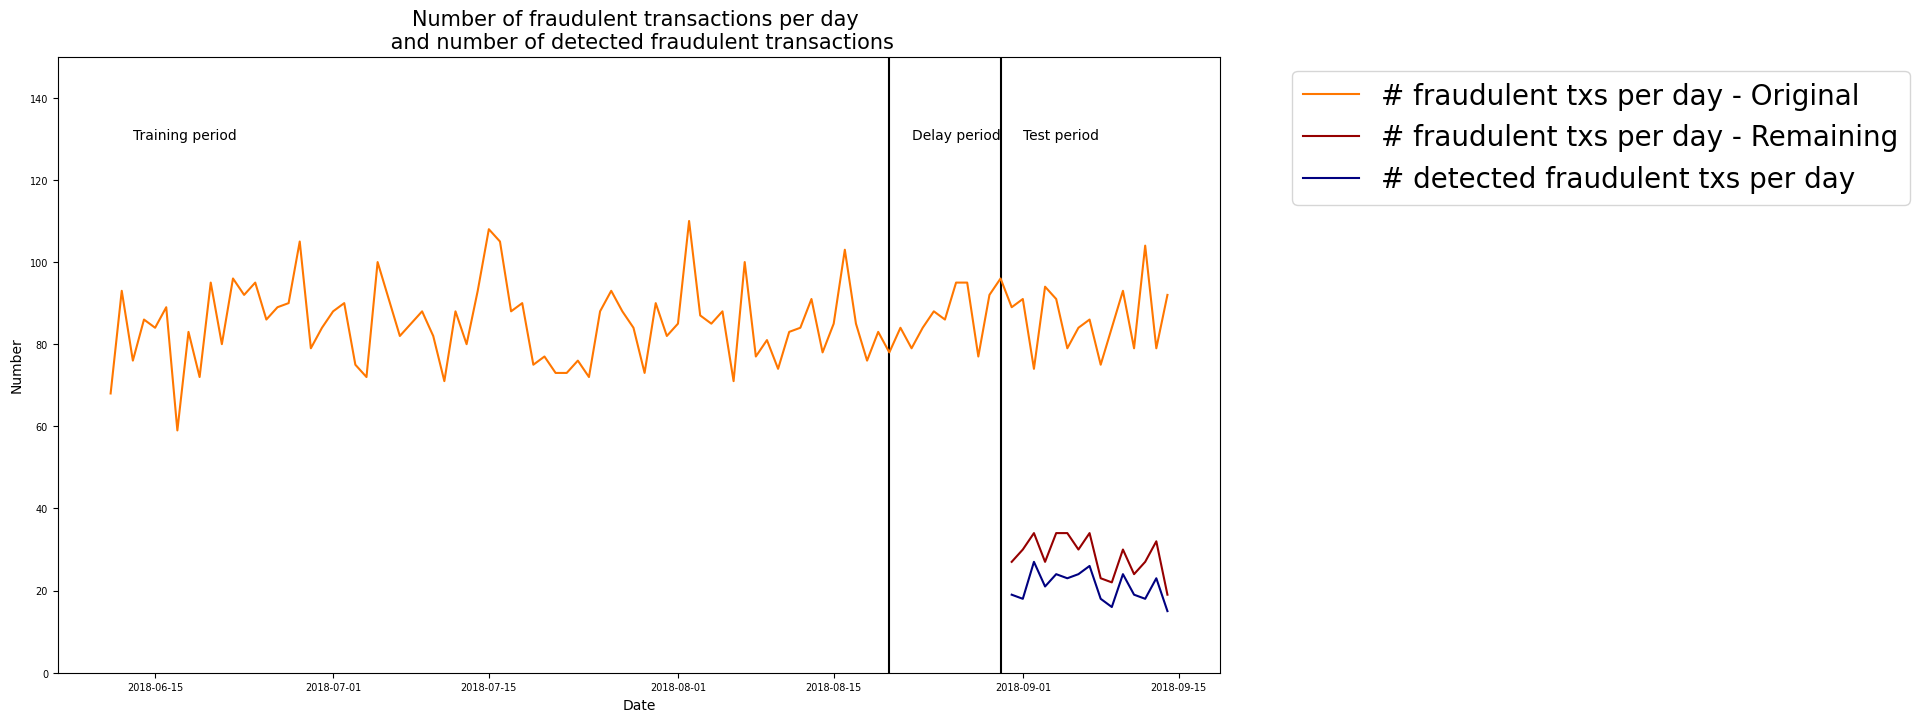

In [56]:


# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'precision_top_k_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200),
        'nb_fraudulent_transactions_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-06-11", "%Y-%m-%d")
delta_train = 70 
delta_delay = 10
delta_test = 15

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=10,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day_remaining'], 'b', color=colors['nb_fraudulent_transactions_per_day_remaining'], label = '# fraudulent txs per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['precision_top_k_per_day']*100, 'b', color=colors['precision_top_k_per_day'], label = '# detected fraudulent txs per day')
ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)
    

## Card Precision Top-k

In [58]:
day=151

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

_,card_precision_top_k= card_precision_top_k_day(df_day=df_day, top_k=100)
card_precision_top_k

0.18

In [59]:
df_day.groupby('CUSTOMER_ID').max().TX_FRAUD.sum()

26